In [1]:
#!/usr/bin/env python
"""
Bayesian neural network for binary classification using mean-field variational inference.
(see, e.g., Blundell et al. (2015); Kucukelbir et al. (2016))
Inspired by autograd's Bayesian neural network example.

Probability model:
    Bayesian neural network
    Prior: Normal
    Likelihood: Bernoulli parameterized by fully connected NN
Variational model
    Likelihood: Mean-field Normal
"""
import edward as ed
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


import pprint
from random import shuffle

from edward.models import Variational, Normal
from edward.stats import norm,bernoulli, beta
from edward.util import rbf

import seaborn as sns
sns.set_style('white')

from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [2]:
%matplotlib inline

In [3]:
# Rotate the samples just for fun
angle = 45.
theta = (angle/180.) * np.pi

rotMatrix = np.array([[np.cos(theta), -np.sin(theta)], 
                         [np.sin(theta),  np.cos(theta)]])

X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)

X = scale(np.matmul(rotMatrix,X.T).T)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.15)


train_data = tf.constant(np.column_stack((Y_train, X_train)),dtype=tf.float32)
test_data = tf.constant(np.column_stack((Y_test, X_test)),dtype=tf.float32)


In [5]:
class BayesianNN:
    """
    Bayesian neural network for regressing outputs y on inputs x.

    p((x,y), z) = Normal(y | NN(x; z), lik_variance) *
                  Normal(z | 0, prior_variance),

    where z are neural network weights, and with known lik_variance
    and prior_variance.

    Parameters
    ----------
    layer_sizes : list
        The size of each layer, ordered from input to output.
    nonlinearity : function, optional
        Non-linearity after each linear transformation in the neural
        network; aka activation function.
    lik_variance : float, optional
        Variance of the normal likelihood; aka noise parameter,
        homoscedastic variance, scale parameter.
    prior_variance : float, optional
        Variance of the normal prior on weights; aka L2
        regularization parameter, ridge penalty, scale parameter.
    """
    def __init__(self, layer_sizes, nonlinearity=tf.nn.tanh,
        lik_variance=0.01, prior_variance=0.001):
        self.layer_sizes = layer_sizes
        self.nonlinearity = nonlinearity
        self.lik_variance = lik_variance
        self.prior_variance = prior_variance

        self.num_layers = len(layer_sizes)
        self.weight_dims = list(zip(layer_sizes[:-1], layer_sizes[1:]))
        self.num_vars = sum((m+1)*n for m, n in self.weight_dims)

    def unpack_weights(self, z):
        """Unpack weight matrices and biases from a flattened vector."""
        for m, n in self.weight_dims:
            yield tf.reshape(z[:m*n],        [m, n]), \
                  tf.reshape(z[m*n:(m*n+n)], [1, n])
            z = z[(m+1)*n:]

    def mapping(self, x, z):
        """
        mu = NN(x; z)

        Note this is one sample of z at a time.

        Parameters
        -------
        x : tf.tensor
            n_data x D

        z : tf.tensor
            num_vars

        Returns
        -------
        tf.tensor
            vector of length n_data
        """
        h = x
        for W, b in self.unpack_weights(z):
            # broadcasting to do (h*W) + b (e.g. 40x10 + 1x10)
            h = self.nonlinearity(tf.matmul(h, W) + b)

        h = tf.squeeze(tf.sigmoid(h)) # n_data x 1 to n_data
        return h

    def log_prob(self, xs, zs):
        """Returns a vector [log p(xs, zs[1,:]), ..., log p(xs, zs[S,:])]."""
        # Data must have labels in the first column and features in
        # subsequent columns.
        y = xs[:, 0]
        x = xs[:, 1:]        
        
        log_prior = -self.prior_variance * tf.reduce_sum(zs*zs, 1)
        ps = tf.pack([self.mapping(x, z) for z in tf.unpack(zs)])
        
        log_lik = -tf.reduce_sum((bernoulli.logpmf(1-y, p=ps)))/ self.lik_variance
        return log_lik + log_prior
      
ed.set_seed(42)
model = BayesianNN(layer_sizes=[2, 5, 5, 1], nonlinearity=tf.nn.tanh)
variational = Variational()
variational.add(Normal(model.num_vars))
#data = build_toy_dataset()

In [6]:
# Helper function for creating data batches
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [9]:
sess = ed.get_session()

batch_size = 100
batch_list = list(chunks(list(range(0, X_train.shape[0])), batch_size))
batches_num = int(X_train.shape[0] / batch_size)
idx = list(range(X_train.shape[0]))
x = tf.placeholder(tf.float32, [batch_size,3])
data = ed.Data(x)
inference = ed.MFVI(model, variational, data)
inference.initialize(n_print=10)

In [10]:
for t in range(200):
    avg_loss = 0.0
    shuffle(idx)
    X_train_shuffle = X_train[idx,:]
    Y_train_shuffle = Y_train[idx]
    for n in range(batches_num):
        
        train_batch = (np.column_stack((Y_train_shuffle[batch_list[n]], X_train_shuffle[batch_list[n],:])))
        _, loss = sess.run([inference.train, inference.loss],
                           feed_dict={x: train_batch})
        avg_loss += loss
        
    avg_loss = avg_loss / batches_num
    # Print a lower bound to the average marginal likelihood for an
    # image.
    print("avg. loss {:0.3f}".format(avg_loss))
        

avg. loss 7494.650
avg. loss 7901.369
avg. loss 8361.561
avg. loss 8760.004
avg. loss 9132.342
avg. loss 8770.510
avg. loss 9699.225
avg. loss 9593.642
avg. loss 10622.880
avg. loss 10728.248
avg. loss 11017.365
avg. loss 11205.836
avg. loss 11618.955
avg. loss 11602.899
avg. loss 11675.446
avg. loss 11547.532
avg. loss 11520.106
avg. loss 11636.578
avg. loss 11502.921
avg. loss 11785.764
avg. loss 11642.531
avg. loss 11763.159
avg. loss 11638.041
avg. loss 11633.896
avg. loss 11660.482
avg. loss 11692.328
avg. loss 11728.927
avg. loss 11738.264
avg. loss 11822.192
avg. loss 11753.493
avg. loss 11743.785
avg. loss 11840.298
avg. loss 11754.153
avg. loss 11558.262
avg. loss 11757.162
avg. loss 11804.815
avg. loss 11805.153
avg. loss 11720.048
avg. loss 11704.670
avg. loss 11803.081
avg. loss 11685.540
avg. loss 11822.612
avg. loss 11784.605
avg. loss 11827.992
avg. loss 11890.309
avg. loss 11786.829
avg. loss 11892.083
avg. loss 11974.657
avg. loss 11839.375
avg. loss 11967.530
avg. los

In [12]:
# Sample variational parameters
mean, std = sess.run([variational.layers[0].m,
                              variational.layers[0].s])
rs = np.random.RandomState(0)
zs = rs.randn(50, variational.num_vars) * std + mean
zs = tf.constant(zs, dtype=tf.float32)

In [13]:

p = tf.pack([model.mapping(tf.constant(X_test,dtype=tf.float32), z) for z in tf.unpack(zs)])
pred = np.squeeze(p.eval().mean(axis=0) >= 0.5)
wrong_pred_0 = np.where(np.logical_and(np.squeeze(Y_test)!= pred, np.squeeze(Y_test) == 0))
wrong_pred_1 = np.where(np.logical_and(np.squeeze(Y_test)!= pred, np.squeeze(Y_test) == 1))

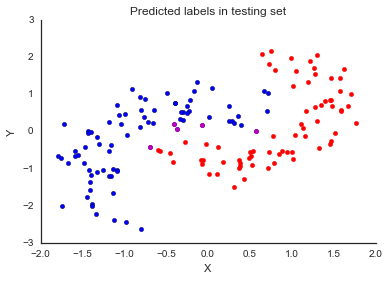

In [15]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
ax.scatter(X_test[wrong_pred_1, 0], X_test[wrong_pred_1, 1], color='m')
ax.scatter(X_test[wrong_pred_0, 0], X_test[wrong_pred_0, 1], color='g')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

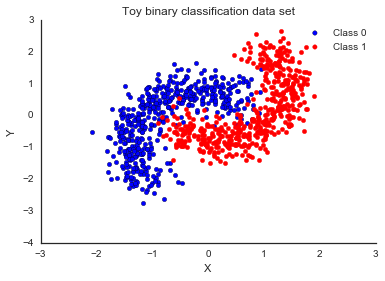

In [16]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [17]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T           

pX = tf.pack([model.mapping(tf.constant(X,dtype=tf.float32), z) for z in tf.unpack(zs)])
pred_X = np.squeeze(pX.eval().mean(axis=0) >= 0.5)              

    
p = tf.pack([model.mapping(tf.constant(grid_2d,dtype=tf.float32), z) for z in tf.unpack(zs)])
pred_grid = np.squeeze(p.eval().mean(axis=0))

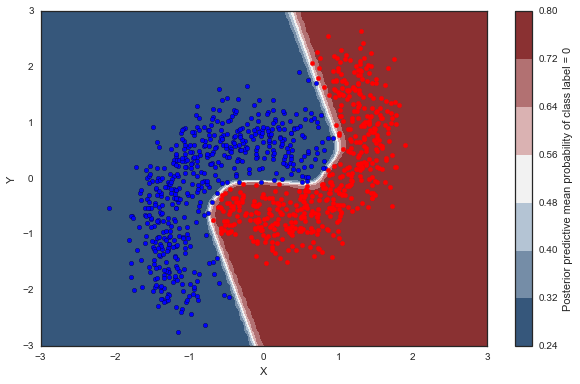

In [19]:


#grid = np.mgrid[100:-3:-3j,-3:3:100j]
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, pred_grid.reshape(100, 100), cmap=cmap)
#ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
#ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
ax.scatter(X[pred_X==0, 0], X[pred_X==0, 1], label='Class 0')
ax.scatter(X[pred_X==1, 0], X[pred_X==1, 1], color='r', label='Class 1')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');